# Neural style transfer

## Setup


### Import and configure modules

In [1]:
import IPython.display as display
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [3]:
# example images 

content_path = '/kaggle/input/style-and-content-images/4971879462.jpg'
style_path = '/kaggle/input/styleeeeee/Astronaut Doge _ Doge.png'

## Visualize the input

In [5]:
def load_img(path_to_img):
  max_dim = 224 # reshape size for both content and style images
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  #new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, (224,224))
  img = img[tf.newaxis, :]
  return img

simple function to display an image:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

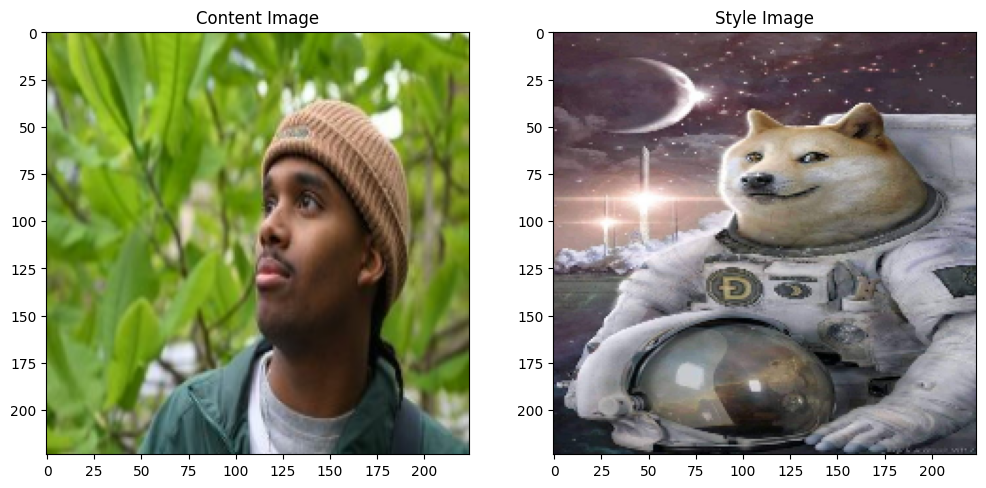

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

it demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style:

### first checking how a benchmark models output look like

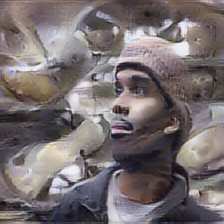

In [9]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As we step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, i used the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Loading a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on  image to ensure it's used correctly:

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')


80134624/80134624 [==============================] - 2s 0us/step


## Now load a `VGG19` without the classification head, and list the layer names

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # include top = false means it neglect the last classification layer

print()
for layer in vgg.layers:
  print(layer.name)


input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [17]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.



In [15]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs) #define a model using the functional API, specify the inputs and outputs
  return model

And to create the model:

In [18]:
style_extractor = vgg_layers(style_layers)   # style feature extractor 
style_outputs = style_extractor(style_image*255) # content image feature extraction

# statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 224, 224, 64)
  min:  0.0
  max:  852.8865
  mean:  23.856777

block2_conv1
  shape:  (1, 112, 112, 128)
  min:  0.0
  max:  3634.0034
  mean:  146.66107

block3_conv1
  shape:  (1, 56, 56, 256)
  min:  0.0
  max:  6222.991
  mean:  150.13747

block4_conv1
  shape:  (1, 28, 28, 512)
  min:  0.0
  max:  15147.109
  mean:  657.41077

block5_conv1
  shape:  (1, 14, 14, 512)
  min:  0.0
  max:  4867.134
  mean:  68.43811



## style calculation

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [19]:
# gram matrix implementation

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [20]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [21]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.018195441
    max:  23193.684
    mean:  477.43118

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  122062.805
    mean:  14712.356

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1426035.2
    mean:  18819.979

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  12073392.0
    mean:  262451.62

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  194335.02
    mean:  3604.6987

Contents:
   block5_conv2
    shape:  (1, 14, 14, 512)
    min:  0.0
    max:  1745.2565
    mean:  23.514698


## Run gradient descent

With this style and content extractor, i implemented the style transfer algorithm. 

In [22]:
style_targets = extractor(style_image)['style']  # it has style features 
content_targets = extractor(content_image)['content'] # it has content features of batch only 1

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [23]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [25]:
def clip_0_1(image):   # clipping image pixel values between 0 and 1 
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

 optimizer and weight initialization

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [28]:
# to optimize model, used a weighted combination of the two losses to get the total loss

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [29]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

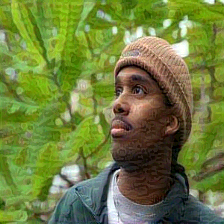

In [30]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, i tried to optimize it for a longer run

In [ ]:
# running for 50 epochs 

import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

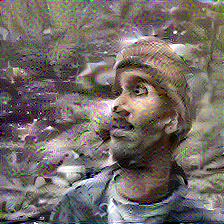

In [33]:
# here is the final output after optimizing the model for 18 epochs and 1800 steps 
# this image looks quite realistic and have the combination of both images

display.display(tensor_to_image(image))

#                                                Part 2

## CNN based encoder architecture for fearure extraction ******

most of the parts of code are similar to the above implemented code, so i havent used much comments, sorry for this

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D

## encoder architecture inspired from autoencoder

In [35]:


def autoencoder():
    inputs = Input(shape = (224,224,3))
    #encoder
   
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same',name = 'conv1')(inputs) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same',name = 'conv2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same',name = 'conv3')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',name = 'conv4')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) 
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same',name = 'conv5')(pool4)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same',name = 'conv6')(conv5)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same',name = 'conv7')(conv6)
    model = Model(inputs = inputs,outputs = conv7)
    return model
   


In [36]:
autoencoder = autoencoder()
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 56, 56, 32)        4640

### next few steps are similar to the steps which i had performed for VGG 19, it is inspired from that model only

In [37]:
for layers in autoencoder.layers:
    print(layers.name)

input_6
conv1
max_pooling2d
conv2
max_pooling2d_1
conv3
max_pooling2d_2
conv4
max_pooling2d_3
conv5
conv6
conv7


In [38]:
content_layers = ['conv6'] # 2nd last year of conv is used for content features

style_layers = ['conv1', # style layers
                'conv2',
                'conv3', 
                'conv4', 
                'conv5']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [39]:
def encoder_layer(layer_names):
  
  
  CNN_model = autoencoder
  CNN_model.trainable = True
  
  outputs = [CNN_model.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([CNN_model.input], outputs)
  return model

In [41]:
style_extractor = encoder_layer(style_layers)
style_outputs = style_extractor(style_image*255)

#statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

conv1
  shape:  (1, 224, 224, 8)
  min:  0.0
  max:  477.09113
  mean:  51.29835

conv2
  shape:  (1, 112, 112, 16)
  min:  0.0
  max:  290.58292
  mean:  38.173683

conv3
  shape:  (1, 56, 56, 32)
  min:  0.0
  max:  208.16818
  mean:  24.52229

conv4
  shape:  (1, 28, 28, 64)
  min:  0.0
  max:  122.03815
  mean:  10.896363

conv5
  shape:  (1, 14, 14, 128)
  min:  0.0
  max:  114.020744
  mean:  7.6507344



## style calculation 

In [42]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## extract style and content 

In [43]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.encoder = encoder_layer(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.encoder.trainable = True

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    #preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.encoder(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [44]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   conv1
    shape:  (1, 8, 8)
    min:  0.0
    max:  42336.324
    mean:  2353.175

   conv2
    shape:  (1, 16, 16)
    min:  0.0
    max:  16471.887
    mean:  1277.8513

   conv3
    shape:  (1, 32, 32)
    min:  0.0
    max:  10391.762
    mean:  526.1299

   conv4
    shape:  (1, 64, 64)
    min:  0.0
    max:  3538.378
    mean:  105.83887

   conv5
    shape:  (1, 128, 128)
    min:  0.0
    max:  3934.22
    mean:  49.24992

Contents:
   conv6
    shape:  (1, 14, 14, 128)
    min:  0.0
    max:  49.955418
    mean:  5.1690006


#### run gradient descent 

In [45]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [47]:
image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [49]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

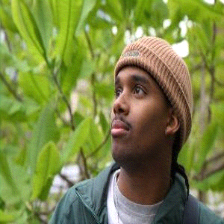

In [51]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)   # without optimization image generated by this CNN architecture

# optimization 

output after 0 epochs


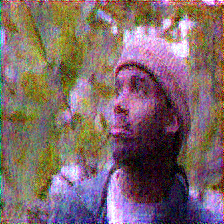

Train step: 100
output after 10 epochs


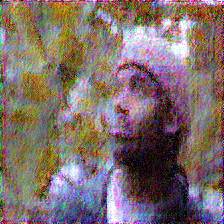

Train step: 1100
output after 20 epochs


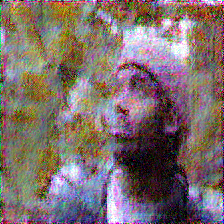

Train step: 2100
output after 30 epochs


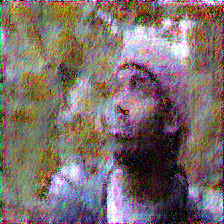

Train step: 3100
output after 40 epochs


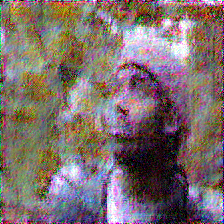

Train step: 4100
Total time: 120.2


In [52]:
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    #print(".", end='', flush=True)
    
  if n%10 == 0:
      print(f'output after {n} epochs')
  #display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

# you can see the results after optimization are getting better as compare to no optimized CNN model